In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

2024-11-19 07:18:24.400062: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 07:18:24.417660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 07:18:24.417679: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 07:18:24.417689: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 07:18:24.421241: I tensorflow/core/platform/cpu_feature_g

(5320, 3547, 3)


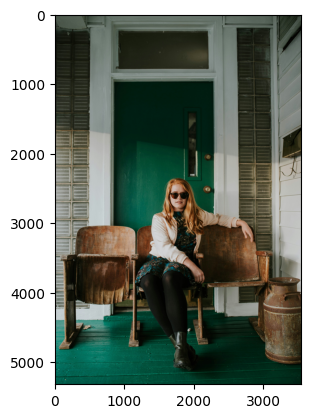

In [2]:
image_name = 'person.png'

img_path = '/workspace/aiffel/human_segmentation/images/' + image_name
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

model_dir = '/workspace/aiffel/human_segmentation/models'
model_file = os.path.join(
    model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

2024-11-19 07:18:26.056587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 07:18:26.056696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 07:18:26.056742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
from PIL import Image
image = Image.open(img_path)
if image.mode != "RGB":
    image = image.convert("RGB")
    # 변환된 이미지를 저장
    convert_image = 'convert_' + image_name
    converted_path = '/workspace/aiffel/human_segmentation/images/convert/' + convert_image
    image.save(converted_path)
    img_path = converted_path  # img_path를 변환된 이미지로 업데이트
    img_orig = cv2.imread(img_path)
else:
    converted_path = img_path
    
segvalues, output = model.segmentAsPascalvoc(converted_path)

1/1 [==============================] - 1s 1s/step


2024-11-19 07:18:29.365541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


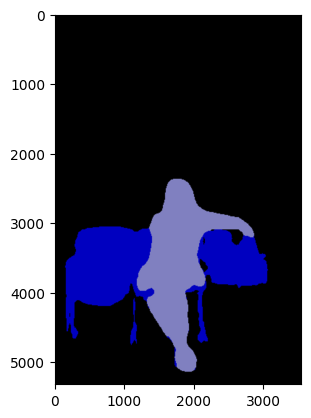

In [5]:
plt.imshow(output)
plt.show()

In [6]:
for class_id in segvalues['class_ids']:
    print(f'{LABEL_NAMES[class_id]} : {class_id}')

background : 0
chair : 9
person : 15


In [7]:
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [8]:
change_colormap = colormap[15]   # 하드코딩

In [9]:
seg_color = change_colormap[[2,1,0]] 

(5320, 3547)


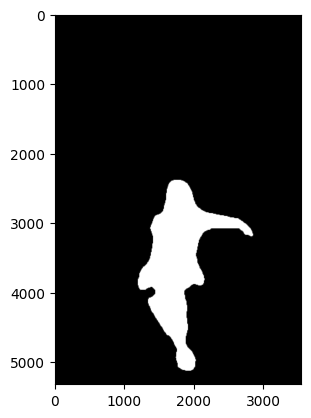

In [10]:
seg_map = np.all(output == seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

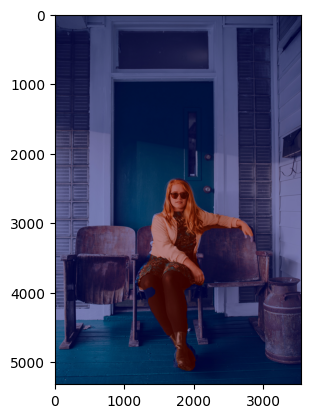

In [11]:
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
# rotate
# img_mask = cv2.rotate(img_mask, cv2.ROTATE_90_CLOCKWISE)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

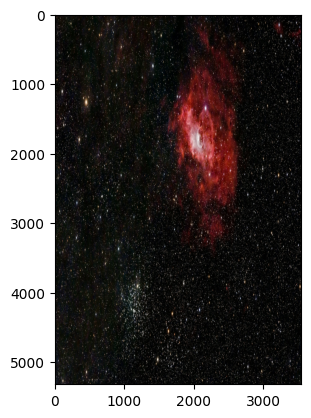

In [12]:
img_background_path = '/workspace/aiffel/human_segmentation/images/background.jpg'
img_background = cv2.imread(img_background_path)
#Warning Rotate!
img_background = cv2.resize(img_background, (seg_map.shape[1], seg_map.shape[0]))
plt.imshow(cv2.cvtColor(img_background, cv2.COLOR_BGR2RGB))
plt.show()

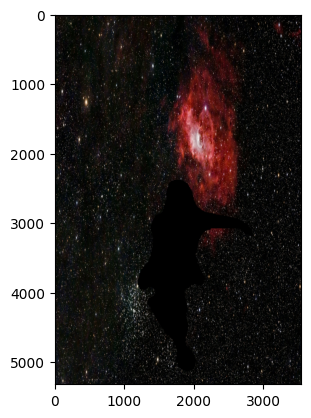

In [13]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_background, img_bg_mask)

plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()

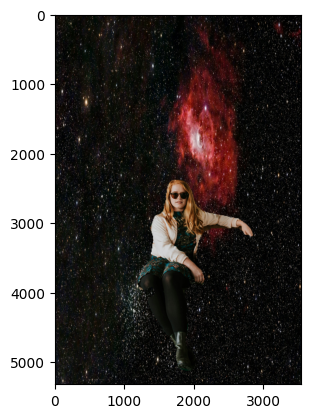

In [14]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg)

chromakey_image = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)

plt.imshow(chromakey_image)
plt.show()

In [15]:
chromakey_image = cv2.cvtColor(chromakey_image, cv2.COLOR_RGB2BGR)
save_name = image_name[:-4] + '_chromakey.png'
save_path = '/workspace/aiffel/human_segmentation/images/image_change/' + save_name
cv2.imwrite(save_path, chromakey_image)

True